# Coral Bleaching
## Predicting the Likelihood and Severity of Coral Reef Bleaching Events Based on Various Environmental Factors

Authors: Jaimie Chin & Maro Aboelwafa  
Course: DS.UA.301 - Advanced Topics in Data Science: Machine Learning for Climate Change  
Date: 22 March 2023  

## Background
The climate issue we are tackling is predicting the likelihood and severity of coral reef bleaching events based on various environmental factors. Coral reefs are sensitive to environmental changes such as temperature, salinity, nutrient levels and water acidity. When these factors reach certain thresholds, they  trigger coral bleaching, a process in which the coral expels the symbiotic algae that live on it, causing the coral to turn white and possibly die.

To address this, we aim to use machine learning to analyze datasets of environmental data, such as water temperature to develop algorithms that can predict the likelihood and severity of coral bleaching events.

### Data 
We will be using the Bleaching and environmental data for global coral reef sites (1980-2020) from the Biological & Chemical Oceanography Data Management Office. The data includes information on the presence and absence of coral bleaching, allowing comparative analyses and the determination of geographical bleaching thresholds, together with site exposure, distance to land, mean turbidity, cyclone frequency, and a suite of sea-surface temperature metrics at the times of survey. 

Data Server: [Bleaching and Environmental Data](http://dmoserv3.whoi.edu/jg/info/BCO-DMO/Coral_Reef_Brightspots/bleaching_and_env_data%7Bdir=dmoserv3.whoi.edu/jg/dir/BCO-DMO/Coral_Reef_Brightspots/,data=dmoserv3.bco-dmo.org:80/jg/serv/BCO-DMO/Coral_Reef_Brightspots/global_bleaching_environmental.brev0%7D?)


## Import Packages

In [107]:
# Import packages & libraries 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
import plotly.express as px

## Load Dataset 

In [39]:
# Import Global Bleaching & Environmental Data 
data_path = "data/global_bleaching_environmental.csv"
types = {'Distance_to_Shore': float, 'Turbidity': float, 'Percent_Bleaching': float}
bleach_df = pd.read_csv(data_path, sep='\s*[,]\s*', engine='python', na_values=['nd'], dtype=types)

In [40]:
# View sample of the data 
bleach_df.sample(5)

Site_ID  Sample_ID Data_Source  Latitude_Degrees  Longitude_Degrees  \
32380     1759   10316885  Reef_Check           -3.8747           -33.8038   
13082     4344   10321085  Reef_Check            1.4108            97.6107   
18323     7352   10312994  Reef_Check           10.0669           125.1344   
16435     6004   10310145  Reef_Check            5.7128           115.6724   
12302     3792   10320552  Reef_Check           16.4788           -85.9214   

      Ocean_Name                  Reef_ID            Realm_Name  \
32380   Atlantic    33.48.13.65W.3.52.29S     Tropical Atlantic   
13082     Indian     97.36.38.5E.1.24.39N  Western Indo-Pacific   
18323    Pacific     125.08.04E.10.04.01N  Central Indo-Pacific   
16435    Pacific  115.40.20.8E.5.42.46.1N  Central Indo-Pacific   
12302   Atlantic    85.55.286W.16.28.725N     Tropical Atlantic   

                    Ecoregion_Name Country_Name  ... TSA_FrequencyMax  \
32380                       Brazil       Brazil  ...              6.0   
13082                 West Sumatra    Indonesia  ...             16.0   
18323       South-east Philippines  Philippines  ...             13.0   
16435  Sunda Shelf south-east Asia     Malaysia  ...              5.0   
12302    Belize and west Caribbean     Honduras  ...              9.0   

      TSA_FrequencyMean TSA_DHW  TSA_DHW_Standard_Deviation TSA_DHWMax  \
32380               0.0    0.00                        0.72       8.67   
13082               3.0    1.05                        2.22      17.11   
18323               1.8    3.04                        1.89      15.72   
16435               1.0    0.00                        1.01       7.06   
12302               1.0    0.00                        1.39      13.51   

       TSA_DHWMean        Date  Site_Comments  Sample_Comments  \
32380         0.15  2010-12-05            NaN              NaN   
13082         1.03  2005-07-21            NaN              NaN   
18323         0.79  2010-07-06            NaN              NaN   
16435         0.41  2016-04-17            NaN              NaN   
12302         0.40  2003-04-23            NaN              NaN   

       Bleaching_Comments  
32380                 NaN  
13082                 NaN  
18323                 NaN  
16435                 NaN  
12302                 NaN  

[5 rows x 62 columns]

## Data Cleaning & Exploration

In [41]:
# Let's first see how large our dataset is for evaluation 
bleach_df.shape

(41361, 62)

### Feature Information & Null Values 
Let's observe our features to determine what could be used in our model analysis

In [42]:
# Let's see out features and datatypes 
bleach_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41361 entries, 0 to 41360
Data columns (total 62 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Site_ID                                41361 non-null  int64  
 1   Sample_ID                              41361 non-null  int64  
 2   Data_Source                            41361 non-null  object 
 3   Latitude_Degrees                       41361 non-null  float64
 4   Longitude_Degrees                      41361 non-null  float64
 5   Ocean_Name                             41361 non-null  object 
 6   Reef_ID                                28821 non-null  object 
 7   Realm_Name                             41361 non-null  object 
 8   Ecoregion_Name                         41358 non-null  object 
 9   Country_Name                           41360 non-null  object 
 10  State_Island_Province_Name             41262 non-null  object 
 11  Ci

In [43]:
# Let's see our null values for each feature 
# Number of missing data within each attribute
null_df = pd.DataFrame(bleach_df.isna().sum(), columns=['Null_Count'])
null_df[null_df['Null_Count'] != 0]

Null_Count
Reef_ID                                     12540
Ecoregion_Name                                  3
Country_Name                                    1
State_Island_Province_Name                     99
City_Town_Name                               1133
Site_Name                                   34429
Distance_to_Shore                               2
Turbidity                                       6
Depth_m                                      1799
Substrate_Name                              12668
Percent_Cover                               12455
Bleaching_Level                             18830
Percent_Bleaching                            6846
ClimSST                                       113
Temperature_Kelvin                            148
Temperature_Mean                              132
Temperature_Minimum                           132
Temperature_Maximum                           132
Temperature_Kelvin_Standard_Deviation         132
Windspeed                                     129
SSTA                                          148
SSTA_Standard_Deviation                       132
SSTA_Mean                                     132
SSTA_Minimum                                  176
SSTA_Maximum                                  132
SSTA_Frequency                                148
SSTA_Frequency_Standard_Deviation             132
SSTA_FrequencyMax                             132
SSTA_FrequencyMean                            132
SSTA_DHW                                      148
SSTA_DHW_Standard_Deviation                   132
SSTA_DHWMax                                   132
SSTA_DHWMean                                  132
TSA                                           148
TSA_Standard_Deviation                        132
TSA_Minimum                                   132
TSA_Maximum                                   132
TSA_Mean                                      132
TSA_Frequency                                 148
TSA_Frequency_Standard_Deviation              132
TSA_FrequencyMax                              132
TSA_FrequencyMean                             132
TSA_DHW                                       148
TSA_DHW_Standard_Deviation                    132
TSA_DHWMax                                    132
TSA_DHWMean                                   132
Site_Comments                               39104
Sample_Comments                             38403
Bleaching_Comments                          38692

Looking at the number of null values for each feature, our target feature **Percent_Bleaching** have a higher number of null values than we would like. For better accuracy and generalizability, we may decide to drop all samples that do not have our target feature.

Otherwise, looking at the other null values, it seems that there are some features that can be dropped due to its irrelevancy within Coral Bleaching literature, and some features that can use imputed score. How we will impute these scores will be determined. 

### Dropping Irrelevant/Redundant Features 
Based on prior literature, we can drop some irrelevant and redundant features:
1. Site_ID - Irrelevant to predicting bleaching events due to coral environment
2. Sample_ID - Irrelevant to predicting bleaching events due to coral environment
3. Data_Source (Source of data set) - Irrelevant to predicting bleaching events due to coral environment 
4. Date_Day - Month and Year are more generalizable for this data 
5. Date - Month and Year are more generalizable for this data
6. Reef_ID (Unique identifier from Reef Check data) - Irrelevant to predicting bleaching events due to coral environment 
7. State_Island_Province_Name (The state, territory (e.g., Guam) or island group (e.g., Hawaiian Islands) where sampling took place) - Already using latitude and longitude
8. City_Town_Name (The region, city, or nearest town, where sampling took place) - Already using latitude and longitude
9. Site_Name (The accepted name of the site or the name given by the team that sampled the reef) - Irrelevant to predicting bleaching events due to coral environment 
10. Bleaching_Level (Reef Check data, coral population or coral colony) - Less detailed than target feature 'Percent_Bleaching'
11. Site_Comments - Too variant and many nulls
12. Sample_Comments - Too variant and many nulls
13. Bleaching_Comments - Too variant and many nulls

In [44]:
# Drop irrelevant/redundant features
bleach_CL_df = bleach_df.drop(['Site_ID', 'Sample_ID', 'Data_Source', 'Date_Day', 'Date', 'Reef_ID', 'State_Island_Province_Name', 'City_Town_Name',
                                    'Site_Name', 'Bleaching_Level', 'Site_Comments', 'Sample_Comments', 'Bleaching_Comments'], axis=1)

# Drop any rows where the target feature is null and some missing qualitative rows

bleach_CL_df = bleach_CL_df[bleach_CL_df['Percent_Bleaching'].notna()]
bleach_CL_df = bleach_CL_df[bleach_CL_df['Ecoregion_Name'].notna()]
bleach_CL_df = bleach_CL_df[bleach_CL_df['Country_Name'].notna()]

In [45]:
# Let's see the shape of our data again 
bleach_CL_df.shape

(34512, 49)

### Distributions & Visualizations
We need to see some distributions of the features that need to be imputed 

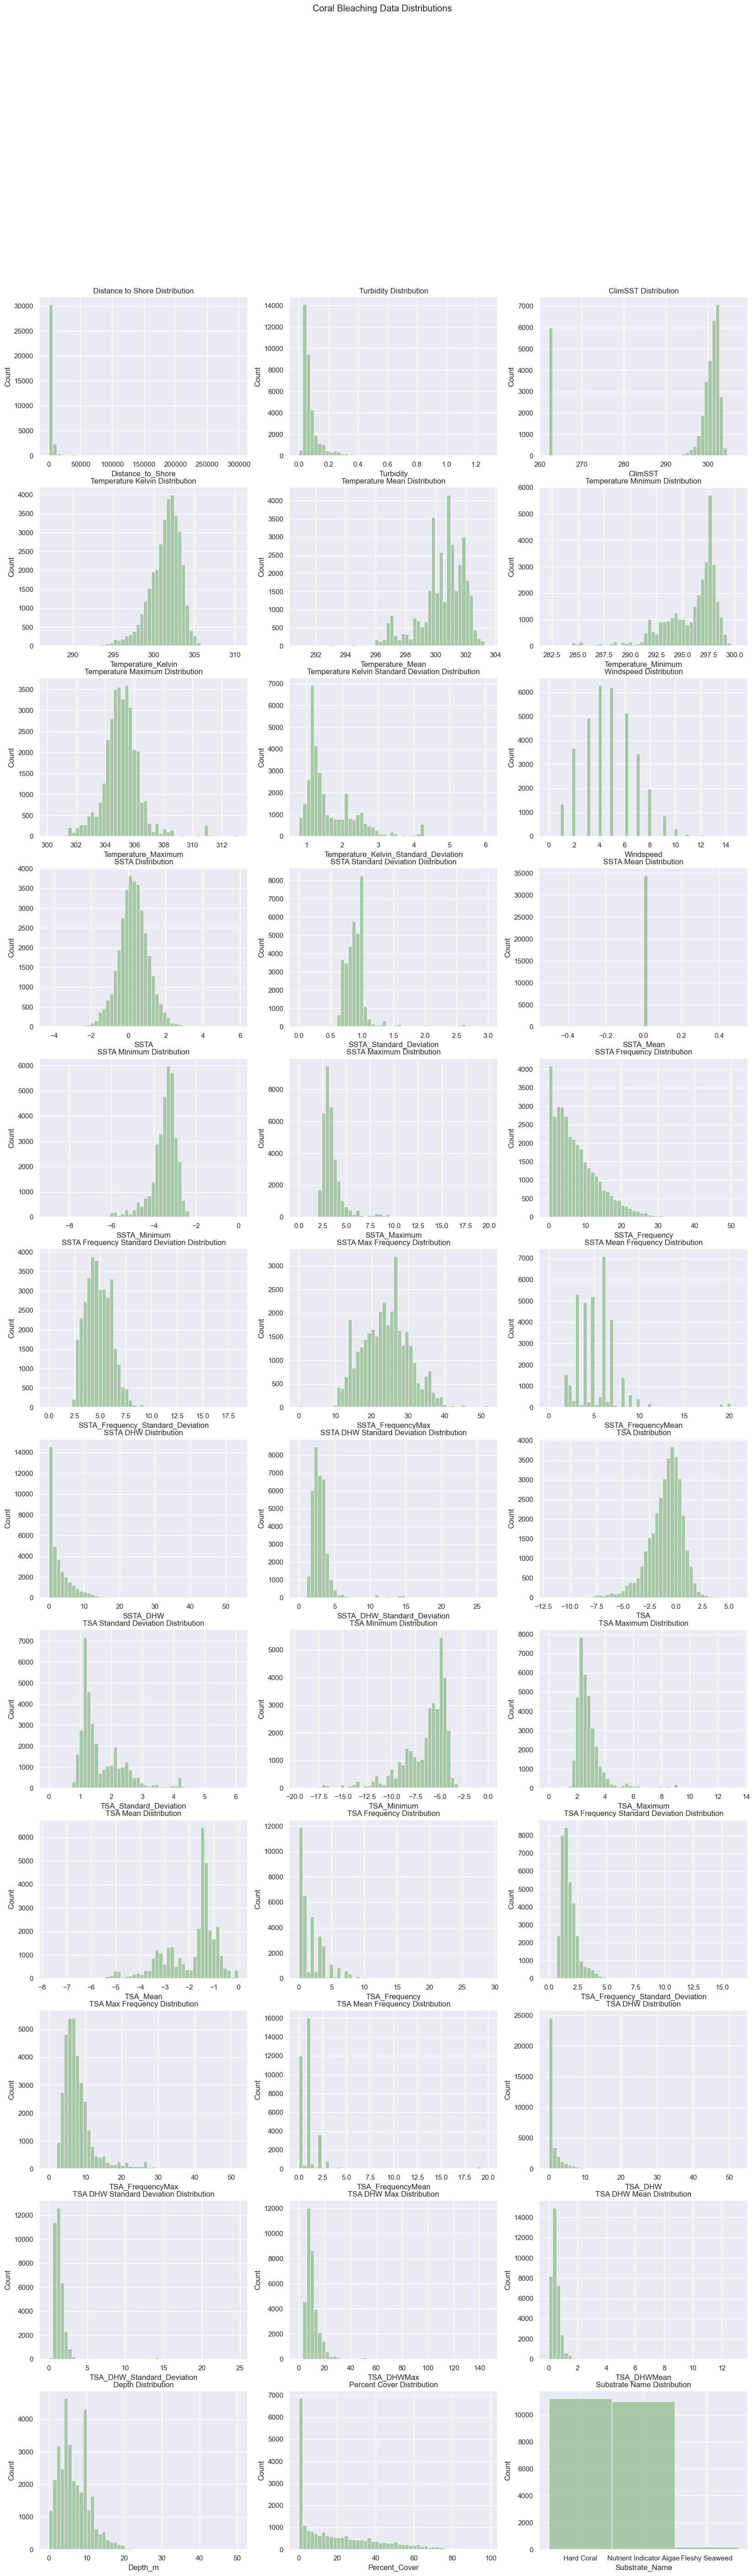

In [46]:
# Set seaborn figure
sns.set(style="darkgrid")
fig, axs = plt.subplots(12, 3, figsize=(20, 64))

# Plotting some relevant features 
fig.suptitle('Coral Bleaching Data Distributions')

sns.histplot(data=bleach_CL_df, x="Distance_to_Shore",
             color="darkseagreen", bins=50, ax=axs[0, 0])
axs[0, 0].set_title('Distance to Shore Distribution')

sns.histplot(data=bleach_CL_df, x="Turbidity",
             color="darkseagreen", bins=50, ax=axs[0, 1])
axs[0, 1].set_title('Turbidity Distribution')

sns.histplot(data=bleach_CL_df, x="ClimSST", color="darkseagreen", bins=50, ax=axs[0, 2])
axs[0, 2].set_title('ClimSST Distribution')

sns.histplot(data=bleach_CL_df, x="Temperature_Kelvin",
             color="darkseagreen", bins=50, ax=axs[1, 0])
axs[1, 0].set_title('Temperature Kelvin Distribution')

sns.histplot(data=bleach_CL_df, x="Temperature_Mean",
             color="darkseagreen", bins=50, ax=axs[1, 1])
axs[1, 1].set_title('Temperature Mean Distribution')

sns.histplot(data=bleach_CL_df, x="Temperature_Minimum",
             color="darkseagreen", bins=50, ax=axs[1, 2])
axs[1, 2].set_title('Temperature Minimum Distribution')

sns.histplot(data=bleach_CL_df, x="Temperature_Maximum",
             color="darkseagreen", bins=50, ax=axs[2, 0])
axs[2, 0].set_title('Temperature Maximum Distribution')

sns.histplot(data=bleach_CL_df, x="Temperature_Kelvin_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[2, 1])
axs[2, 1].set_title('Temperature Kelvin Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="Windspeed",
             color="darkseagreen", bins=50, ax=axs[2, 2])
axs[2, 2].set_title('Windspeed Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA",
             color="darkseagreen", bins=50, ax=axs[3, 0])
axs[3, 0].set_title('SSTA Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[3, 1])
axs[3, 1].set_title('SSTA Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Mean",
             color="darkseagreen", bins=50, ax=axs[3, 2])
axs[3, 2].set_title('SSTA Mean Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Minimum",
             color="darkseagreen", bins=50, ax=axs[4, 0])
axs[4, 0].set_title('SSTA Minimum Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Maximum",
             color="darkseagreen", bins=50, ax=axs[4, 1])
axs[4, 1].set_title('SSTA Maximum Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Frequency",
             color="darkseagreen", bins=50, ax=axs[4, 2])
axs[4, 2].set_title('SSTA Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Frequency_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[5, 0])
axs[5, 0].set_title('SSTA Frequency Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_FrequencyMax",
             color="darkseagreen", bins=50, ax=axs[5, 1])
axs[5, 1].set_title('SSTA Max Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_FrequencyMean",
             color="darkseagreen", bins=50, ax=axs[5, 2])
axs[5, 2].set_title('SSTA Mean Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_DHW",
             color="darkseagreen", bins=50, ax=axs[6, 0])
axs[6, 0].set_title('SSTA DHW Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_DHW_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[6, 1])
axs[6, 1].set_title('SSTA DHW Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="TSA",
             color="darkseagreen", bins=50, ax=axs[6, 2])
axs[6, 2].set_title('TSA Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[7, 0])
axs[7, 0].set_title('TSA Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Minimum",
             color="darkseagreen", bins=50, ax=axs[7, 1])
axs[7, 1].set_title('TSA Minimum Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Maximum",
             color="darkseagreen", bins=50, ax=axs[7, 2])
axs[7, 2].set_title('TSA Maximum Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Mean",
             color="darkseagreen", bins=50, ax=axs[8, 0])
axs[8, 0].set_title('TSA Mean Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Frequency",
             color="darkseagreen", bins=50, ax=axs[8, 1])
axs[8, 1].set_title('TSA Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Frequency_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[8, 2])
axs[8, 2].set_title('TSA Frequency Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_FrequencyMax",
             color="darkseagreen", bins=50, ax=axs[9, 0])
axs[9, 0].set_title('TSA Max Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_FrequencyMean",
             color="darkseagreen", bins=50, ax=axs[9, 1])
axs[9, 1].set_title('TSA Mean Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_DHW",
             color="darkseagreen", bins=50, ax=axs[9, 2])
axs[9, 2].set_title('TSA DHW Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_DHW_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[10, 0])
axs[10, 0].set_title('TSA DHW Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_DHWMax",
             color="darkseagreen", bins=50, ax=axs[10, 1])
axs[10, 1].set_title('TSA DHW Max Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_DHWMean",
             color="darkseagreen", bins=50, ax=axs[10, 2])
axs[10, 2].set_title('TSA DHW Mean Distribution')

sns.histplot(data=bleach_CL_df, x="Depth_m",
             color="darkseagreen", bins=50, ax=axs[11, 0])
axs[11, 0].set_title('Depth Distribution')

sns.histplot(data=bleach_CL_df, x="Percent_Cover",
             color="darkseagreen", bins=50, ax=axs[11, 1])
axs[11, 1].set_title('Percent Cover Distribution')

sns.histplot(data=bleach_CL_df, x="Substrate_Name",
             color="darkseagreen", ax=axs[11, 2])
axs[11, 2].set_title('Substrate Name Distribution')

plt.show()

Looking at the distributions for features that are missing data, each feature has a generally skewed distribution.

We decided to use the Multiple Imputation Method to impute our data given that our goal is to impute values that are unbiased (and are therefore generalizable) and recovers the population variance, which is critical to statistical inference for our prediction models. 

### Data Imputation 

In [47]:
# Create a copy of our data 
bleach_na_df = bleach_CL_df.copy()[['Distance_to_Shore', 'Turbidity', 'Depth_m', 'Percent_Cover', 
                                    'ClimSST', 'Temperature_Kelvin', 'Temperature_Mean', 'Temperature_Minimum', 
                                    'Temperature_Maximum', 'Temperature_Kelvin_Standard_Deviation', 'Windspeed', 
                                    'SSTA', 'SSTA_Standard_Deviation', 'SSTA_Mean',  'SSTA_Minimum', 
                                    'SSTA_Maximum', 'SSTA_Frequency', 'SSTA_Frequency_Standard_Deviation', 
                                    'SSTA_FrequencyMax', 'SSTA_FrequencyMean', 'SSTA_DHW', 
                                    'SSTA_DHW_Standard_Deviation', 'SSTA_DHWMax', 'SSTA_DHWMean', 'TSA', 
                                    'TSA_Standard_Deviation', 'TSA_Minimum', 'TSA_Maximum', 'TSA_Mean', 
                                    'TSA_Frequency', 'TSA_Frequency_Standard_Deviation', 'TSA_FrequencyMax', 
                                    'TSA_FrequencyMean', 'TSA_DHW', 'TSA_DHW_Standard_Deviation', 'TSA_DHWMax', 
                                    'TSA_DHWMean']]                                                                                                                                                                                                                                                                                                                                                                                                                                            

# Instantiate Imputer
imputer = IterativeImputer(random_state=0, max_iter=10)

# Fit on the dataset 
imputer.fit(bleach_na_df)
bleach_imputed_df = imputer.transform(bleach_na_df)

# Replace clean dataframe with imputed values
bleach_CL_df.loc[:, ['Distance_to_Shore', 'Turbidity', 'Depth_m', 'Percent_Cover',
                     'ClimSST', 'Temperature_Kelvin', 'Temperature_Mean', 'Temperature_Minimum',
                     'Temperature_Maximum', 'Temperature_Kelvin_Standard_Deviation', 'Windspeed',
                     'SSTA', 'SSTA_Standard_Deviation', 'SSTA_Mean',  'SSTA_Minimum',
                     'SSTA_Maximum', 'SSTA_Frequency', 'SSTA_Frequency_Standard_Deviation',
                     'SSTA_FrequencyMax', 'SSTA_FrequencyMean', 'SSTA_DHW',
                     'SSTA_DHW_Standard_Deviation', 'SSTA_DHWMax', 'SSTA_DHWMean', 'TSA',
                     'TSA_Standard_Deviation', 'TSA_Minimum', 'TSA_Maximum', 'TSA_Mean',
                     'TSA_Frequency', 'TSA_Frequency_Standard_Deviation', 'TSA_FrequencyMax',
                     'TSA_FrequencyMean', 'TSA_DHW', 'TSA_DHW_Standard_Deviation', 'TSA_DHWMax',
                     'TSA_DHWMean']] = bleach_imputed_df

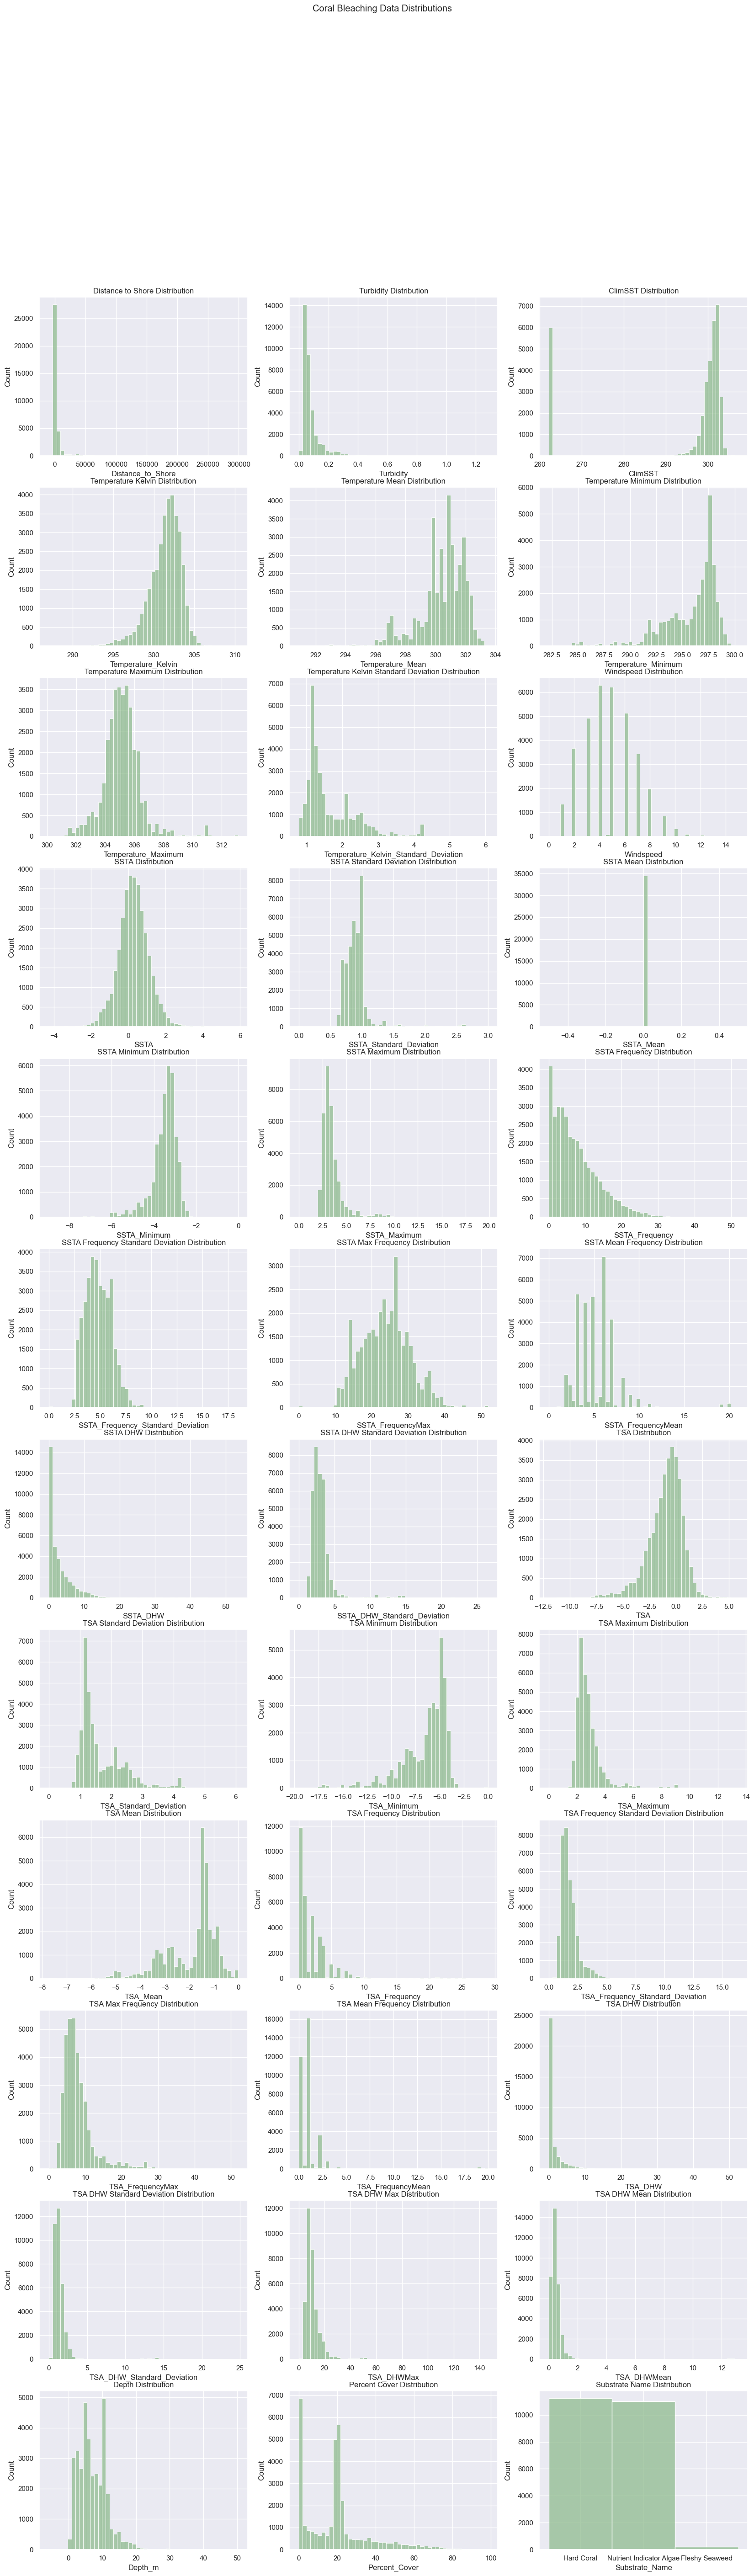

In [48]:
# Let's check our distributions one more time to see how our imputed data looks
# Set seaborn figure
sns.set(style="darkgrid")
fig, axs = plt.subplots(12, 3, figsize=(20, 64))

# Plotting some relevant features
fig.suptitle('Coral Bleaching Data Distributions')

sns.histplot(data=bleach_CL_df, x="Distance_to_Shore",
             color="darkseagreen", bins=50, ax=axs[0, 0])
axs[0, 0].set_title('Distance to Shore Distribution')

sns.histplot(data=bleach_CL_df, x="Turbidity",
             color="darkseagreen", bins=50, ax=axs[0, 1])
axs[0, 1].set_title('Turbidity Distribution')

sns.histplot(data=bleach_CL_df, x="ClimSST",
             color="darkseagreen", bins=50, ax=axs[0, 2])
axs[0, 2].set_title('ClimSST Distribution')

sns.histplot(data=bleach_CL_df, x="Temperature_Kelvin",
             color="darkseagreen", bins=50, ax=axs[1, 0])
axs[1, 0].set_title('Temperature Kelvin Distribution')

sns.histplot(data=bleach_CL_df, x="Temperature_Mean",
             color="darkseagreen", bins=50, ax=axs[1, 1])
axs[1, 1].set_title('Temperature Mean Distribution')

sns.histplot(data=bleach_CL_df, x="Temperature_Minimum",
             color="darkseagreen", bins=50, ax=axs[1, 2])
axs[1, 2].set_title('Temperature Minimum Distribution')

sns.histplot(data=bleach_CL_df, x="Temperature_Maximum",
             color="darkseagreen", bins=50, ax=axs[2, 0])
axs[2, 0].set_title('Temperature Maximum Distribution')

sns.histplot(data=bleach_CL_df, x="Temperature_Kelvin_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[2, 1])
axs[2, 1].set_title('Temperature Kelvin Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="Windspeed",
             color="darkseagreen", bins=50, ax=axs[2, 2])
axs[2, 2].set_title('Windspeed Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA",
             color="darkseagreen", bins=50, ax=axs[3, 0])
axs[3, 0].set_title('SSTA Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[3, 1])
axs[3, 1].set_title('SSTA Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Mean",
             color="darkseagreen", bins=50, ax=axs[3, 2])
axs[3, 2].set_title('SSTA Mean Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Minimum",
             color="darkseagreen", bins=50, ax=axs[4, 0])
axs[4, 0].set_title('SSTA Minimum Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Maximum",
             color="darkseagreen", bins=50, ax=axs[4, 1])
axs[4, 1].set_title('SSTA Maximum Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Frequency",
             color="darkseagreen", bins=50, ax=axs[4, 2])
axs[4, 2].set_title('SSTA Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_Frequency_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[5, 0])
axs[5, 0].set_title('SSTA Frequency Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_FrequencyMax",
             color="darkseagreen", bins=50, ax=axs[5, 1])
axs[5, 1].set_title('SSTA Max Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_FrequencyMean",
             color="darkseagreen", bins=50, ax=axs[5, 2])
axs[5, 2].set_title('SSTA Mean Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_DHW",
             color="darkseagreen", bins=50, ax=axs[6, 0])
axs[6, 0].set_title('SSTA DHW Distribution')

sns.histplot(data=bleach_CL_df, x="SSTA_DHW_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[6, 1])
axs[6, 1].set_title('SSTA DHW Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="TSA",
             color="darkseagreen", bins=50, ax=axs[6, 2])
axs[6, 2].set_title('TSA Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[7, 0])
axs[7, 0].set_title('TSA Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Minimum",
             color="darkseagreen", bins=50, ax=axs[7, 1])
axs[7, 1].set_title('TSA Minimum Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Maximum",
             color="darkseagreen", bins=50, ax=axs[7, 2])
axs[7, 2].set_title('TSA Maximum Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Mean",
             color="darkseagreen", bins=50, ax=axs[8, 0])
axs[8, 0].set_title('TSA Mean Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Frequency",
             color="darkseagreen", bins=50, ax=axs[8, 1])
axs[8, 1].set_title('TSA Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_Frequency_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[8, 2])
axs[8, 2].set_title('TSA Frequency Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_FrequencyMax",
             color="darkseagreen", bins=50, ax=axs[9, 0])
axs[9, 0].set_title('TSA Max Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_FrequencyMean",
             color="darkseagreen", bins=50, ax=axs[9, 1])
axs[9, 1].set_title('TSA Mean Frequency Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_DHW",
             color="darkseagreen", bins=50, ax=axs[9, 2])
axs[9, 2].set_title('TSA DHW Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_DHW_Standard_Deviation",
             color="darkseagreen", bins=50, ax=axs[10, 0])
axs[10, 0].set_title('TSA DHW Standard Deviation Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_DHWMax",
             color="darkseagreen", bins=50, ax=axs[10, 1])
axs[10, 1].set_title('TSA DHW Max Distribution')

sns.histplot(data=bleach_CL_df, x="TSA_DHWMean",
             color="darkseagreen", bins=50, ax=axs[10, 2])
axs[10, 2].set_title('TSA DHW Mean Distribution')

sns.histplot(data=bleach_CL_df, x="Depth_m",
             color="darkseagreen", bins=50, ax=axs[11, 0])
axs[11, 0].set_title('Depth Distribution')

sns.histplot(data=bleach_CL_df, x="Percent_Cover",
             color="darkseagreen", bins=50, ax=axs[11, 1])
axs[11, 1].set_title('Percent Cover Distribution')

sns.histplot(data=bleach_CL_df, x="Substrate_Name",
             color="darkseagreen", ax=axs[11, 2])
axs[11, 2].set_title('Substrate Name Distribution')

plt.show()

In [49]:
# Let's check for any missing values again 
# Number of missing data within each feature
null_df = pd.DataFrame(bleach_CL_df.isna().sum(), columns=['Null_Count'])
null_df[null_df['Null_Count'] != 0]

Null_Count
Substrate_Name       12044

It seems that the only feature left is a qualitative feature with 12,044 missing values. We could impute this with the most frequent value, but this method does not consider dependencies among feature values. We think it is better to drop this feature all together to preserve sample size. 

In [50]:
# Let's drop the 'substrate_name' feature from our dataset 
bleach_CL_df = bleach_CL_df.drop(['Substrate_Name'], axis=1)

In [51]:
# Final shape of the dataset
bleach_CL_df.shape

(34512, 48)

## Splitting the Data for Model Building and Analysis 

Now that we have cleaned the dataset, we want to split our data into 3 datasets, a training set (to train our model), a test set (to test our final model after adjusting parameters), and a validation set to validate our model's hyperparameters.

In [52]:
# Split entire dataset into a train and test set 
train_df, test_df = train_test_split(bleach_CL_df, test_size=0.2, random_state=0)

# Separate target feature from the train and test sets 
y_test = test_df['Percent_Bleaching'].copy()
X_test = test_df.drop(['Percent_Bleaching'], axis=1)

per_bleach_df = train_df['Percent_Bleaching'].copy()
train_df = train_df.drop(['Percent_Bleaching'], axis=1)

# Split the train dataset into train and validation set
X_train, X_val, y_train, y_val = train_test_split(
    train_df, per_bleach_df, test_size=0.2, random_state=0)


In [53]:
# Let's check the sizes of our data sets 
print(f"No. of training examples: {X_train.shape[0]}")
print(f"No. of validating examples: {X_val.shape[0]}")
print(f"No. of testing examples: {X_test.shape[0]}")

No. of training examples: 22087
No. of validating examples: 5522
No. of testing examples: 6903


## Encoding Categorical Features 

In [55]:
# Save feature names
features = X_train.columns

# Save longitude & latitude for visualizations later 
X_test_longitude = X_test['Longitude_Degrees'].copy()
X_test_latitude = X_test['Latitude_Degrees'].copy()
X_test_year = X_test['Date_Year'].copy()

# label encode any categorical features
le = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        X_train[column] = le.fit_transform(X_train[column].values.reshape(-1, 1))
        X_val[column] = le.transform(X_val[column].values.reshape(-1, 1))
        X_test[column] = le.transform(X_test[column].values.reshape(-1, 1))

## Feature Selection (Mutual Information-Based Feature Selection) -- TO CHANGE LATER

Now that we have our dataset to build the model, we want to do some preprocessing to reduce the amount of features used in building our model. Our current dataset has 48 features. 

We decided to use the Mutual Information-Based Feature Selection Method because for a dataset with 48 features that has a mix of both numerical and categorical data, we want to evaluate the mutual information between the target variable and each feature in the dataset. The mutual information between two variables measures the amount of information that one variable provides about the other. In other words, it measures how much knowledge of one variable reduces the uncertainty of the other variable.

Mutual information-based feature selection is a suitable method for datasets with a mix of numerical and categorical features because it is a non-parametric method that can handle different types of variables. It works by calculating the mutual information between the target variable and each feature, regardless of their data type. This method can identify relevant features that might be missed by other feature selection methods that rely on correlation measures, which only capture linear relationships between numerical variables.

Furthermore, mutual information-based feature selection can capture non-linear relationships between variables, which is important in many real-world problems. It can also handle redundant features, meaning that it can identify features that might be highly correlated with each other but do not provide any additional information about the target variable.

In [18]:
# Let's standardize our data before feature selection 
# Data Preprocessing
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_val = sc_x.transform(X_val)
X_test = sc_x.transform(X_test)


In [19]:
# select the k best features based on mutual information
selector = SelectKBest(f_regression, k=15)

# Instantiate selected data sets with selected features only
X_train_selected = selector.fit_transform(X_train, y_train)
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test)

# get the index of the selected features
selected_features_idx = selector.get_support()
selected_features = [x for x, b in zip(features, selected_features_idx) if b]

# Let's see which features we selected
print(selected_features)

['Longitude_Degrees', 'Ocean_Name', 'Realm_Name', 'Ecoregion_Name', 'Date_Year', 'Depth_m', 'Temperature_Kelvin', 'SSTA', 'SSTA_Standard_Deviation', 'SSTA_Frequency', 'SSTA_DHW', 'TSA', 'TSA_Frequency', 'TSA_Frequency_Standard_Deviation', 'TSA_DHW']


## Model Implementation
We'll be training the following 3 different models and seeing which one works best:

-  Random Forest
- Gradient Boosting 
- ANN

## Random Forest Model

In [23]:
# Train a random forest regressor on the training set with the best hyperparameters
rf_base = RandomForestRegressor(random_state=0)
rf_base.fit(X_train_selected, y_train)

# Predict on the validation set
y_pred_r_train = rf_base.predict(X_val_selected)

# Calculate the mean squared error and R-squared on the validation set
rmse_rf_train = mean_squared_error(y_val, y_pred_r_train, squared=False)
r2_rf_train = r2_score(y_val, y_pred_r_train)

print('Baseline Random Forest Validation RMSE:', rmse_rf_train)
print('Baseline Random Forest Validation R-squared:', r2_rf_train)

Baseline Random Forest Validation RMSE: 10.971934640754963
Baseline Random Forest Validation R-squared: 0.6940288801761987


#### There's our original model's performance, it's best to use a gridsearch to find the right hyperparameters for our data and see how much we can improve the model.

In [24]:
# Create a random forest regressor object
rf = RandomForestRegressor(random_state=0)

# Define the hyperparameters to search over in a grid search
param_grid_rf = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a grid search object to find the best hyperparameters
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train_selected, y_train)

# Print the best hyperparameters found in the grid search
print('Best hyperparameters:', grid_search_rf.best_params_)

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}


Our first gridsearch returned the best hyperparameters as - 

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}

But there are a couple more hyperparameters we could adjust, let's confirm we have the best possible model.


In [25]:
# Define the hyperparameters to search over in a grid search
param_grid_rf = {
    'n_estimators': [1000],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False],
}

# Create a grid search object to find the best hyperparameters
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train_selected, y_train)

# Print the best hyperparameters found in the grid search
print('Best hyperparameters:', grid_search_rf.best_params_)

Best hyperparameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}


In [26]:
# Train a random forest regressor on the training set with the best hyperparameters
rf = RandomForestRegressor(**grid_search_rf.best_params_, random_state=0)
rf.fit(X_train_selected, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test_selected)

# Calculate the mean squared error and R-squared on the test set
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

print('Tuned Random Forest Test RMSE:', rmse_rf)
print('Tuned Random Forest Test R-squared:', r2_rf)

Tuned Random Forest Test RMSE: 11.108964727455216
Tuned Random Forest Test R-squared: 0.692018198618785


## Gradient Boosting Model

In [27]:
# Train a gradient boosting regressor on the training set with the best hyperparameters
gbr_base = GradientBoostingRegressor(random_state=0)
gbr_base.fit(X_train_selected, y_train)

# Predict on the validation set
y_pred_gbr_train = gbr_base.predict(X_val_selected)

# Calculate the mean squared error and R-squared on the validation set
rmse_gbr_train = mean_squared_error(y_val, y_pred_gbr_train, squared=False)
r2_gbr_train = r2_score(y_val, y_pred_gbr_train)

print('Baseline Gradient Boosting Validation RMSE:', rmse_gbr_train)
print('Baseline Gradient Boosting Validation R-squared:', r2_gbr_train)

Baseline Gradient Boosting Validation RMSE: 14.006446822709629
Baseline Gradient Boosting Validation R-squared: 0.5013796884282813


#### There's our original model's performance, it's best to use a gridsearch to find the right hyperparameters for our data and see how much we can improve the model.

In [28]:
# Create a gradient boosting regressor object
gbr = GradientBoostingRegressor(random_state=0)

# Define the hyperparameters to search over in a grid search
param_grid_gbr = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [2, 4, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'learning_rate': [0.01, 0.1, 1]
}

# Create a grid search object to find the best hyperparameters
grid_search_gbr = GridSearchCV(estimator=gbr, param_grid=param_grid_gbr, cv=5, scoring='neg_mean_squared_error')
grid_search_gbr.fit(X_train_selected, y_train)

# Print the best hyperparameters found in the grid search
print('Best hyperparameters:', grid_search_gbr.best_params_)

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000}


In [29]:
# Train a gradient boosting regressor on the training set with the best hyperparameters
gbr = GradientBoostingRegressor(**grid_search_gbr.best_params_, random_state=0)
gbr.fit(X_train_selected, y_train)

# Predict on the test set
y_pred_gbr = gbr.predict(X_test_selected)

# Calculate the mean squared error and R-squared on the test set
rmse_gbr = mean_squared_error(y_test, y_pred_gbr, squared=False)
r2_gbr = r2_score(y_test, y_pred_gbr)

print('Tuned Gradient Boosting Test RMSE:', rmse_gbr)
print('Tuned Gradient Boosting Test R-squared:', r2_gbr)

Tuned Gradient Boosting Test RMSE: 11.206984255056312
Tuned Gradient Boosting Test R-squared: 0.6865592897505999


## ANN Model

In [30]:
# Train an MLP regressor on the training set with the best hyperparameters
mlp_base = MLPRegressor(random_state=0)
mlp_base.fit(X_train_selected, y_train)

# Predict on the validation set
y_pred_mlp_train = mlp_base.predict(X_val_selected)

# Calculate the mean squared error and R-squared on the validation set
rmse_mlp_train = mean_squared_error(y_val, y_pred_mlp_train, squared=False)
r2_mlp_train = r2_score(y_val, y_pred_mlp_train)

print('Baseline ANN Validation RMSE:', rmse_mlp_train)
print('Baseline ANN Validation R-squared:', r2_mlp_train)

Baseline ANN Validation RMSE: 14.239540015269787
Baseline ANN Validation R-squared: 0.4846456656862631


/Users/jaimiechin/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### There's our original model's performance, now it's best to use a gridsearch to find the right hyperparameters for our data and see how much we can improve the model.

In [20]:
# Create an MLP regressor object
mlp = MLPRegressor(random_state=0)

# Define the hyperparameters to search over in a grid search
param_grid_mlp = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [5000]
}

# Create a grid search object to find the best hyperparameters
grid_search_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid_mlp, cv=5, scoring='neg_mean_squared_error')
grid_search_mlp.fit(X_train_selected, y_train)

# Print the best hyperparameters found in the grid search
print('Best hyperparameters:', grid_search_mlp.best_params_)

/Users/jaimiechin/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/jaimiechin/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/jaimiechin/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs fa

Best hyperparameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 5000, 'solver': 'adam'}


Our first gridsearch returned the best hyperparameters as - 

{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 5000, 'solver': 'adam'}

But did we find the best amount of layers for our ANN? Let's confirm.

In [21]:
# Define the hyperparameters to search over in a grid search
param_grid_mlp = {
    'hidden_layer_sizes': [(100,), (100,50), (45,30,15)],
    'activation': ['tanh'],
    'solver': ['adam'],
    'alpha': [0.01],
    'learning_rate': ['constant'],
    'max_iter': [5000]
}

# Create a grid search object to find the best hyperparameters
grid_search_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid_mlp, cv=5, scoring='neg_mean_squared_error')
grid_search_mlp.fit(X_train_selected, y_train)

# Print the best hyperparameters found in the grid search
print('Best hyperparameters:', grid_search_mlp.best_params_)

Best hyperparameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 5000, 'solver': 'adam'}


Now that we tested the number of layers, the best hyperparameters now are with 3 layers! But is it the most accurate?

In [22]:
# Train an MLP regressor on the training set with the best hyperparameters
mlp = MLPRegressor(**grid_search_mlp.best_params_, random_state=0)
mlp.fit(X_train_selected, y_train)

# Predict on the test set
y_pred_mlp = mlp.predict(X_test_selected)

# Calculate the mean squared error and R-squared on the test set
rmse_mlp = mean_squared_error(y_test, y_pred_mlp, squared=False)
r2_mlp = r2_score(y_test, y_pred_mlp)

print('Tuned ANN Test RMSE:', rmse_mlp)
print('Tuned ANN Test R-squared:', r2_mlp)

Tuned ANN Test RMSE: 13.431174207005547
Tuned ANN Test R-squared: 0.549799634381367


# Final Stacked Model

In [108]:
# Define the base models
base_models = [('ann', mlp), ('gb', gbr), ('rf', rf)]

# Define the stacking regressor with a random forest meta-model
stacked_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())

# Fit the model on training data
stacked_model.fit(X_train_selected, y_train)

# Predict on test data
y_pred = stacked_model.predict(X_test_selected)

# Define lower and upper thresholds
lower_threshold = 0
upper_threshold = 100

# Apply clipping to predicted values
predictions = np.clip(y_pred, lower_threshold, upper_threshold)

# Calculate the mean squared error and R-squared on the test set
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print('Test RMSE:', rmse)
print('Test R-squared:', r2)

Test RMSE: 10.961840819338288
Test R-squared: 0.7001218232604793


## Final Visualizations 
* Plot coral bleaching severity?

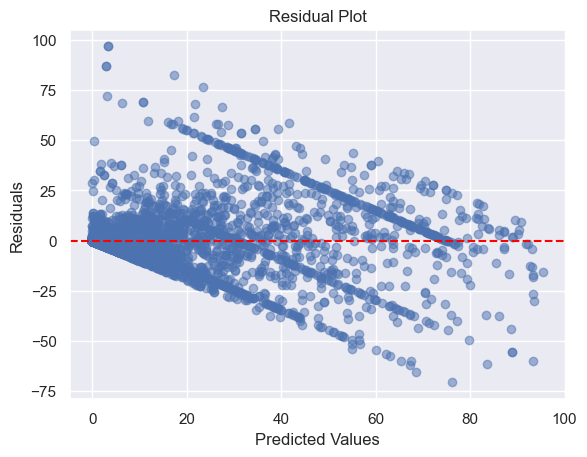

In [115]:
residuals = y_test - predictions

# Create the scatter plot
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [116]:
results = pd.DataFrame({'PREDICTION': predictions, 'ACTUAL': y_test, 'RESIDUALS': np.abs(residuals)})

In [117]:
results['PREDICTED_SEVERITY'] = 0
for index, row in results.iterrows():
    if row.loc['PREDICTION'] > 30:
        results.loc[index, 'PREDICTED_SEVERITY'] = 'SEVERE'
    elif row.loc['PREDICTION'] <= 0:
        results.loc[index, 'PREDICTED_SEVERITY'] = 'LOW'
    elif 0 < row.loc['PREDICTION'] <= 10:
        results.loc[index, 'PREDICTED_SEVERITY'] = 'MILD'
    elif 10 < row.loc['PREDICTION'] <= 30:
        results.loc[index, 'PREDICTED_SEVERITY'] = 'MODERATE'

results['ACTUAL_SEVERITY'] = 0
for index, row in results.iterrows():
    if row.loc['ACTUAL'] > 30:
        results.loc[index, 'ACTUAL_SEVERITY'] = 'SEVERE'
    elif row.loc['ACTUAL'] <= 0:
        results.loc[index, 'ACTUAL_SEVERITY'] = 'LOW'
    elif 0 < row.loc['ACTUAL'] <= 10:
        results.loc[index, 'ACTUAL_SEVERITY'] = 'MILD'
    elif 10 < row.loc['ACTUAL'] <= 30:
        results.loc[index, 'ACTUAL_SEVERITY'] = 'MODERATE'

In [118]:
results.sample(10)

PREDICTION  ACTUAL  RESIDUALS PREDICTED_SEVERITY ACTUAL_SEVERITY
6371     7.613021    5.50   2.113021               MILD            MILD
14912    0.782198    0.00   0.782198               MILD             LOW
33016   24.613135   16.67   7.943135           MODERATE        MODERATE
27364    4.383132    1.63   2.753132               MILD            MILD
16275    1.623154    0.00   1.623154               MILD             LOW
15049    0.822734    0.00   0.822734               MILD             LOW
18799    0.000000    0.00   0.000000                LOW             LOW
12277    0.000000    0.00   0.000000                LOW             LOW
17104    0.047055    0.00   0.047055               MILD             LOW
1514    60.244982   75.00  14.755018             SEVERE          SEVERE

In [119]:
# Create a new data frame for visualizations 
map_df = pd.concat([X_test_longitude, X_test_latitude, X_test_year, results.copy()], axis=1)
map_df.sort_values(by='Date_Year', inplace=True)
map_df

Longitude_Degrees  Latitude_Degrees  Date_Year  PREDICTION  ACTUAL  \
3748           -109.3000          -27.1000       1980   54.571979    30.5   
1402           -109.3333          -27.1667       1980   55.579149    75.0   
1514            106.4833           -5.5167       1983   60.244982    75.0   
5214           -109.4167           23.3333       1987   47.703097     9.4   
6336            -81.8330           24.5400       1987   43.145307     5.5   
...                  ...               ...        ...         ...     ...   
28438            99.8131           10.1172       2020    5.215010     2.5   
31554           115.8945           -8.7495       2020    9.691741     9.0   
30262           116.0504           -8.3439       2020    3.626643     5.0   
34171           116.0858           -8.3487       2020   14.675295    35.0   
32797           116.0376           -8.3376       2020   10.755300    15.0   

       RESIDUALS PREDICTED_SEVERITY ACTUAL_SEVERITY  
3748   24.071979             SEVERE          SEVERE  
1402   19.420851             SEVERE          SEVERE  
1514   14.755018             SEVERE          SEVERE  
5214   38.303097             SEVERE            MILD  
6336   37.645307             SEVERE            MILD  
...          ...                ...             ...  
28438   2.715010               MILD            MILD  
31554   0.691741               MILD            MILD  
30262   1.373357               MILD            MILD  
34171  20.324705           MODERATE          SEVERE  
32797   4.244700           MODERATE        MODERATE  

[6903 rows x 8 columns]

# Actual Coral Bleaching Visualizations
## Actual Coral Bleaching Percentage by Year Visualization

In [157]:
# Plot actual severity on a map
fig = px.scatter_geo(map_df,
                     lat='Latitude_Degrees',
                     lon='Longitude_Degrees',
                     color='ACTUAL',
                     animation_frame='Date_Year',
                     projection='equirectangular',
                     color_continuous_scale=px.colors.sequential.YlOrRd,
                     range_color=[0, 100],
                     width=1000,
                     height=500,
                     title='Actual Coral Bleaching Percentage by Year')

# display the figure
fig.show()

## Actual Categorical Coral Bleaching Severity Visualization

In [163]:
# Plot actual categorical severity on a map, due to limitations with the map library, a for loop will be used
for year in map_df['Date_Year'].unique():

    # Create title for plot
    title = 'Actual Categorical Severity in ' + str(year)

    # Create the plot per year
    fig = px.scatter_geo(map_df[map_df['Date_Year'] == year],
                         lat='Latitude_Degrees',
                         lon='Longitude_Degrees',
                         color='ACTUAL_SEVERITY',
                         projection='equirectangular',
                         category_orders={'ACTUAL_SEVERITY': ['LOW', 'MILD', 'MODERATE', 'SEVERE']},
                         color_discrete_map={
                             'LOW': 'yellow', 'MILD': 'gold', 'MODERATE': 'orange', 'SEVERE': 'firebrick'},
                         width=1000,
                         height=500,
                         title=title)

    # display the figure
    fig.show()

## Predicted Coral Bleaching Percentage by Year Visualization

In [159]:
# Plot predicted severity on a map 
fig = px.scatter_geo(map_df,
                     lat='Latitude_Degrees',
                     lon='Longitude_Degrees',
                     color='PREDICTION',
                     animation_frame='Date_Year',
                     projection='equirectangular',
                     color_continuous_scale=px.colors.sequential.YlOrRd,
                     range_color= [0, 100],
                     width= 1000,
                     height= 500,
                     title='Predicted Coral Bleaching Percentage by Year')

# display the figure
fig.show()

## Predicted Categorical Coral Bleaching Severity Visualization

In [165]:
# Plot predicted categorical severity on a map, due to limitations with the map library, a for loop will be used 
for year in map_df['Date_Year'].unique():

    # Create title for plot
    title = 'Predicted Categorical Severity in ' + str(year)

    # Create the plot per year 
    fig = px.scatter_geo(map_df[map_df['Date_Year'] == year],
                        lat='Latitude_Degrees',
                        lon='Longitude_Degrees',
                        color='PREDICTED_SEVERITY',
                        projection='equirectangular',
                         category_orders={'PREDICTED_SEVERITY': ['LOW', 'MILD', 'MODERATE', 'SEVERE']},
                        color_discrete_map={'LOW': 'yellow', 'MILD': 'gold', 'MODERATE': 'orange', 'SEVERE': 'firebrick'},
                        width=1000,
                        height=500,
                        title=title)

    # display the figure
    fig.show()